In [8]:
# Celda 1: Configuración e Importaciones

import subprocess
import os
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
from IPython.display import display

# --- PARÁMETROS ---

# 1. Carpeta de resultados y binarios
ARCHNAME = f"{platform.system()}_{platform.machine()}"
BIN_DIR = f"{ARCHNAME}/bin"
OUTPUT_DIR = os.path.join(ARCHNAME, "output")

# 2. Ejecutable a usar
EXECUTABLE_NAME = "yee"
EXECUTABLE_PATH = os.path.join(BIN_DIR, EXECUTABLE_NAME)

# 3. Parámetros de la simulación
GRID_LENGTH = "100"

# 4. Nombre del archivo de datos que se generará
DATA_FILE = os.path.join(OUTPUT_DIR, f"yee_pyviz_n{GRID_LENGTH}.tsv")

# --- PREPARACIÓN ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
try:
    subprocess.run(["make", "bin"], check=True)
    print("Compilación verificada.")
except Exception as e:
    print(f"Error al compilar: {e}")

print(f"Listo para generar el archivo de datos: {DATA_FILE}")

make: Nothing to be done for 'bin'.
Compilación verificada.
Listo para generar el archivo de datos: Linux_x86_64/output/yee_pyviz_n100.tsv


In [9]:
# Celda 2: Generar el archivo de datos .tsv (Corregida)

# Construimos el comando SIN el flag '-w', que no es reconocido.
# Al no pasar el flag '-q' (quiet), el programa escribirá el archivo por defecto.
command = [EXECUTABLE_PATH, "-n", GRID_LENGTH, "-o", DATA_FILE]

print(f"Ejecutando comando: {' '.join(command)}")

try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("¡Simulación completada! Salida del programa:")
    # El programa puede que imprima algún mensaje de estado, como el tiempo
    print(result.stdout)
    
    # Verificamos si el archivo de datos fue realmente creado
    if os.path.exists(DATA_FILE):
        print(f"Archivo de datos generado en: {DATA_FILE}")
    else:
        print(f"ADVERTENCIA: La simulación terminó, pero el archivo '{DATA_FILE}' no fue creado.")

except Exception as e:
    print(f"ERROR al ejecutar la simulación: {e}")
    if hasattr(e, 'stderr'):
        print("Error devuelto por el programa:", e.stderr)

Ejecutando comando: Linux_x86_64/bin/yee -n 100 -o Linux_x86_64/output/yee_pyviz_n100.tsv
¡Simulación completada! Salida del programa:
Domain: 100 x 100
Elapsed: 0.000723 seconds
Writing to: Linux_x86_64/output/yee_pyviz_n100.tsv

Archivo de datos generado en: Linux_x86_64/output/yee_pyviz_n100.tsv


Datos cargados exitosamente:


,x,y,z
0,0.005,0.005,0.004124
1,0.005,0.015,0.004824
2,0.005,0.025,0.006289
3,0.005,0.035,0.008642
4,0.005,0.045,0.012066



Imagen guardada en: Linux_x86_64/output/yee_pyviz_n100.png


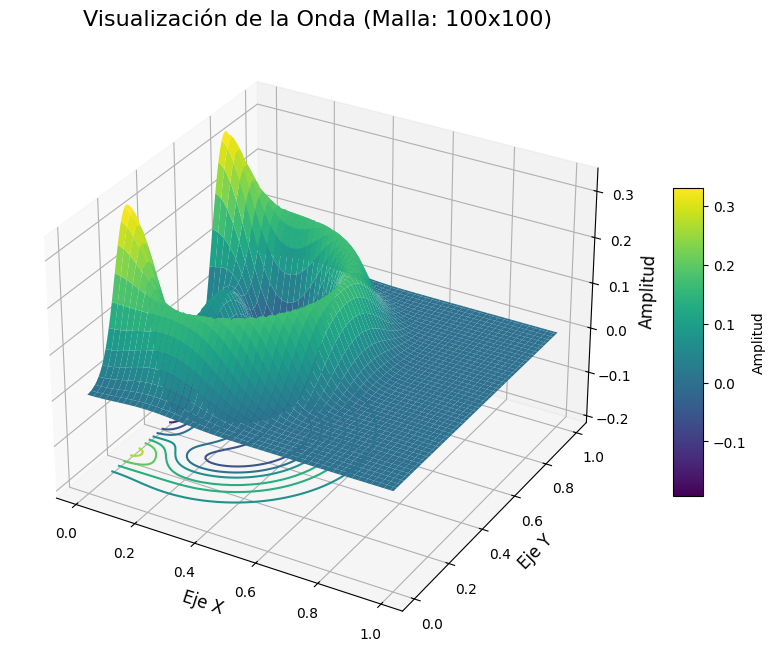

In [10]:
# Celda 3: Leer y Visualizar los Datos con Matplotlib

# 1. Cargar los datos usando pandas
# Asumimos que el archivo TSV tiene 3 columnas: x, y, z (amplitud)
# y no tiene una fila de cabecera.
try:
    data = pd.read_csv(DATA_FILE, sep='\t', header=None, names=['x', 'y', 'z'])
    print("Datos cargados exitosamente:")
    display(data.head())
except FileNotFoundError:
    print(f"ERROR: El archivo de datos '{DATA_FILE}' no fue encontrado. Asegúrate de que la Celda 2 se ejecutó correctamente.")
except Exception as e:
    print(f"ERROR al cargar los datos: {e}")

# 2. Preparar los datos para un gráfico 3D
# Necesitamos convertir las columnas x, y, z en una matriz 2D para la altura Z.
# Esto se conoce como "pivotar" los datos.
X = data['x'].unique()
Y = data['y'].unique()
X, Y = np.meshgrid(X, Y)
Z = data.pivot(index='y', columns='x', values='z').values

# 3. Crear la visualización 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear la superficie 3D con un colormap atractivo como 'viridis' o 'plasma'
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, antialiased=True)

# Añadir una barra de color para la leyenda de la altura
fig.colorbar(surf, shrink=0.5, aspect=10, label='Amplitud')

# Configurar etiquetas y título
ax.set_title(f'Visualización de la Onda (Malla: {GRID_LENGTH}x{GRID_LENGTH})', fontsize=16)
ax.set_xlabel('Eje X', fontsize=12)
ax.set_ylabel('Eje Y', fontsize=12)
ax.set_zlabel('Amplitud', fontsize=12)

# Añadir las líneas de contorno en la base del gráfico
ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.viridis)

# Ajustar el ángulo de la vista
ax.view_init(elev=30., azim=-60)

# Guardar la figura
image_file_py = os.path.join(OUTPUT_DIR, f"yee_pyviz_n{GRID_LENGTH}.png")
plt.savefig(image_file_py, dpi=150, bbox_inches='tight')
print(f"\nImagen guardada en: {image_file_py}")

plt.show()

In [18]:
# --- Celda para generar la animación ---
import imageio.v2 as imageio
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML
import time # <-- ¡CORRECCIÓN! Módulo 'time' importado aquí.

# --- 1. Configuración de Rutas ---
EXPERIMENT_DIR = "experimentos"
FRAMES_DIR = os.path.join(EXPERIMENT_DIR, "anim_frames")
os.makedirs(FRAMES_DIR, exist_ok=True)
gif_output_path = os.path.join(EXPERIMENT_DIR, "animacion_3d.gif")

# --- 2. Encontrar los archivos de datos .tsv ---
data_files = sorted(glob.glob("Linux_x86_64/output/frame_*.tsv"))

if not data_files:
    print("ERROR: No se encontraron archivos de datos 'frame_*.tsv'.")
    print("Asegúrate de haber ejecutado primero la simulación en C modificada.")
else:
    print(f"Encontrados {len(data_files)} archivos de datos. Pre-calculando límites de la animación...")
    
    # --- 3. PASO PREVIO: Encontrar los límites globales del eje Z ---
    all_z_values = []
    for tsv_file in data_files:
        try:
            z_data = pd.read_csv(tsv_file, sep='\t', header=None, usecols=[2], names=['z'])
            if not z_data.empty:
                all_z_values.extend(z_data['z'].tolist())
        except pd.errors.EmptyDataError:
            print(f"Advertencia: El archivo {tsv_file} está vacío y será ignorado.")
            continue
            
    if not all_z_values:
        print("ERROR: No se pudieron leer datos de amplitud de ningún archivo .tsv.")
    else:
        z_min_global = min(all_z_values)
        z_max_global = max(all_z_values)
        print(f"Límites globales de Z calculados: min={z_min_global:.2f}, max={z_max_global:.2f}")

        # --- 4. Generar cada frame .png ---
        print(f"Generando {len(data_files)} imágenes PNG en la carpeta '{FRAMES_DIR}'...")
        
        for i, tsv_file in enumerate(data_files):
            try:
                data = pd.read_csv(tsv_file, sep='\t', header=None, names=['x', 'y', 'z'])
                if data.empty: continue
            except pd.errors.EmptyDataError:
                continue

            X = data['x'].unique()
            Y = data['y'].unique()
            X, Y = np.meshgrid(X, Y)
            Z = data.pivot(index='y', columns='x', values='z').values
            
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            
            surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, vmin=z_min_global, vmax=z_max_global, antialiased=True)
            
            frame_number = int(os.path.basename(tsv_file).split('_')[1].split('.')[0])
            ax.set_title(f'Simulación - Paso de Tiempo {frame_number}')
            ax.set_zlim(z_min_global, z_max_global)
            ax.view_init(elev=30., azim=-60)
            
            frame_path = os.path.join(FRAMES_DIR, f"frame_{i:04d}.png")
            plt.savefig(frame_path, dpi=100)
            plt.close(fig)

        print("¡Todos los frames PNG han sido generados!")

        # --- 5. Ensamblar el GIF a partir de los frames ---
        png_files_in_dir = sorted(glob.glob(os.path.join(FRAMES_DIR, "frame_*.png")))
        
        if not png_files_in_dir:
            print("ERROR: No se encontraron imágenes PNG para crear el GIF.")
        else:
            print(f"Ensamblando {len(png_files_in_dir)} imágenes en un GIF...")
            with imageio.get_writer(gif_output_path, mode='I', duration=0.1, loop=0) as writer:
                for filename in png_files_in_dir:
                    image = imageio.imread(filename)
                    writer.append_data(image)
            
            print(f"¡Animación GIF creada exitosamente en: {gif_output_path}!")
            # El truco con time.time() es para forzar al navegador a recargar la imagen
            # si ejecutas esta celda varias veces, en lugar de mostrar una versión en caché.
            display(HTML(f'<img src="{gif_output_path}?{time.time()}">'))

Encontrados 8 archivos de datos. Pre-calculando límites de la animación...
Límites globales de Z calculados: min=-0.27, max=1.00
Generando 8 imágenes PNG en la carpeta 'experimentos/anim_frames'...
¡Todos los frames PNG han sido generados!
Ensamblando 8 imágenes en un GIF...
¡Animación GIF creada exitosamente en: experimentos/animacion_3d.gif!
